In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

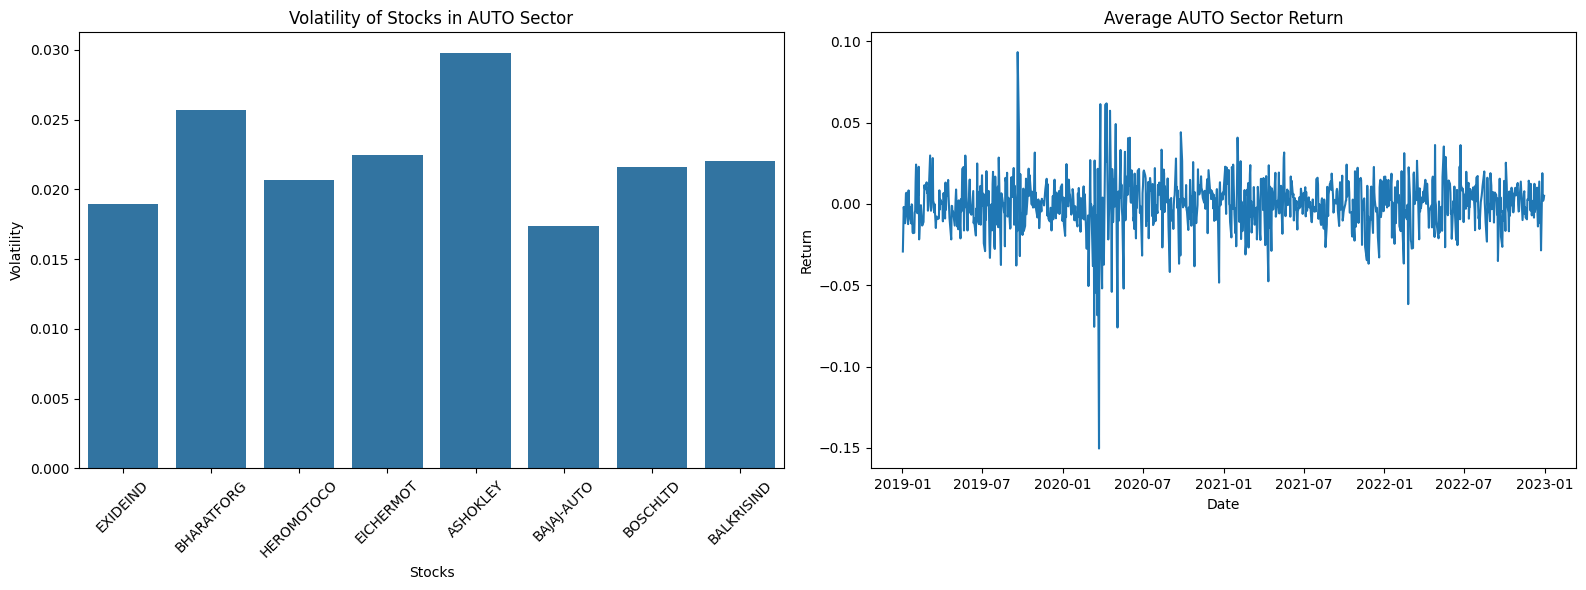

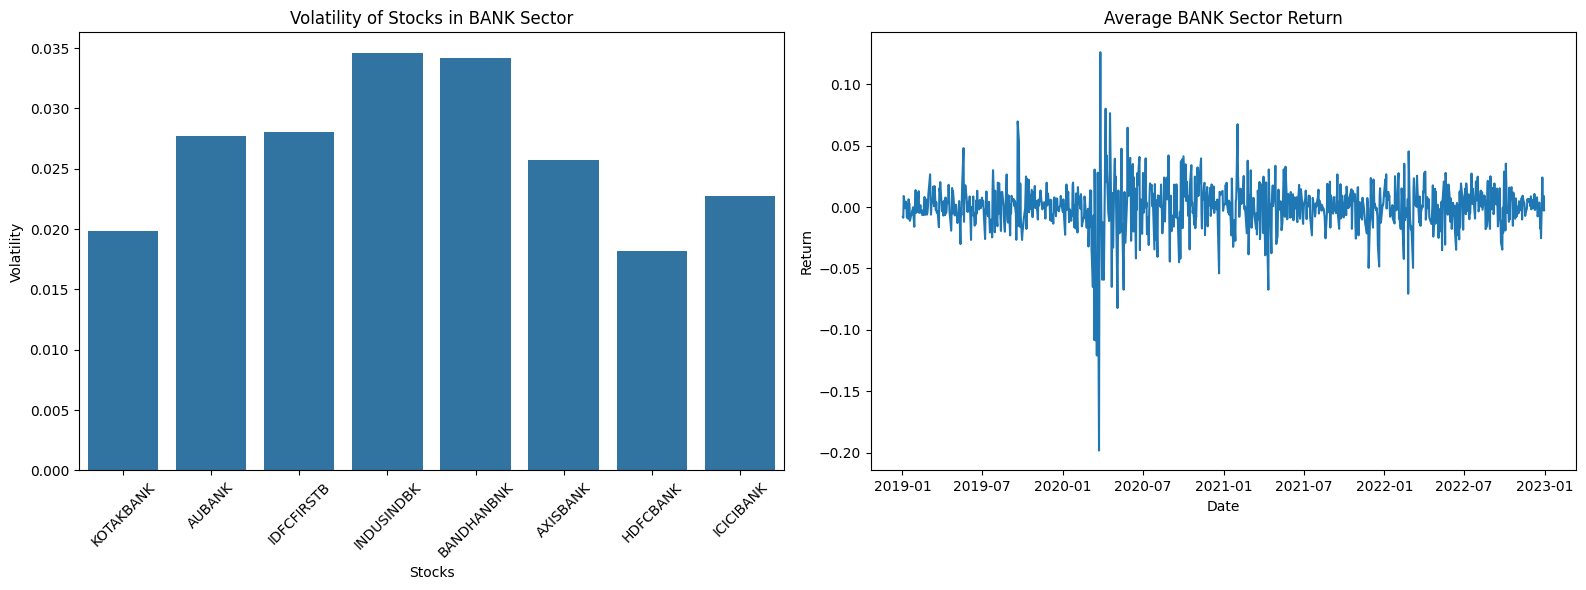

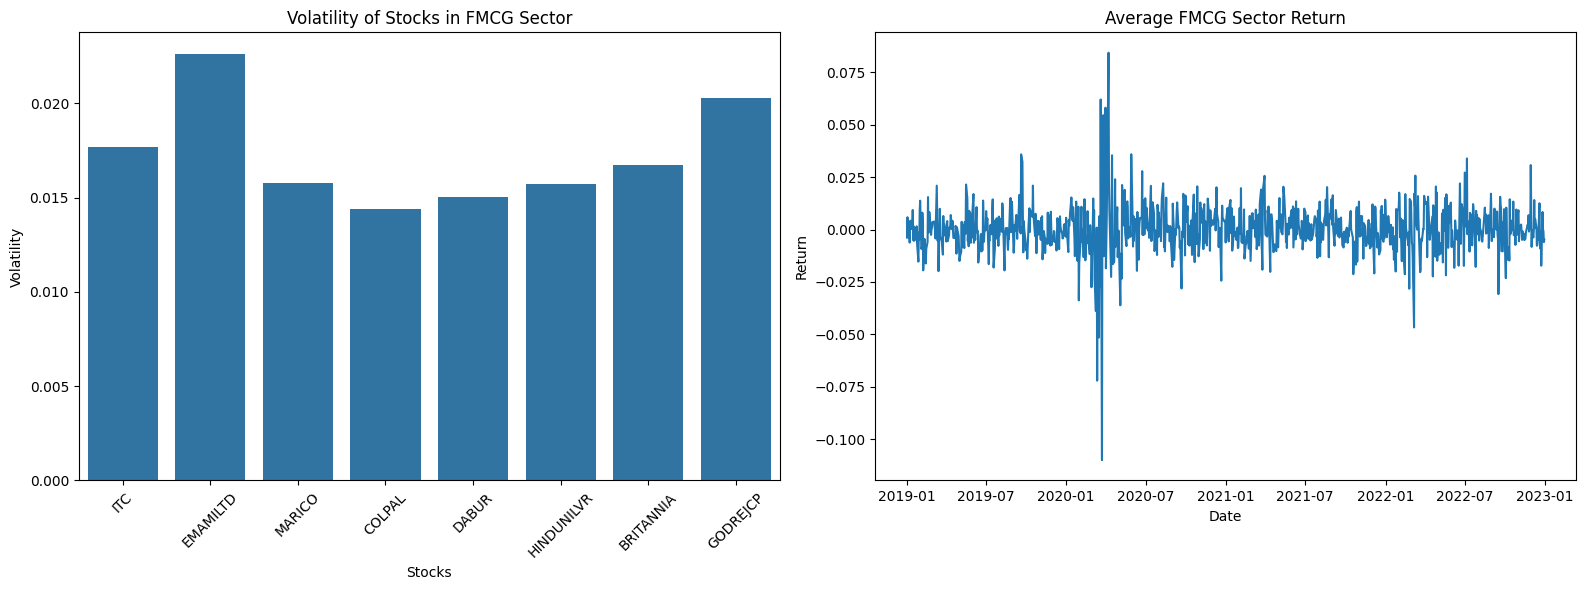

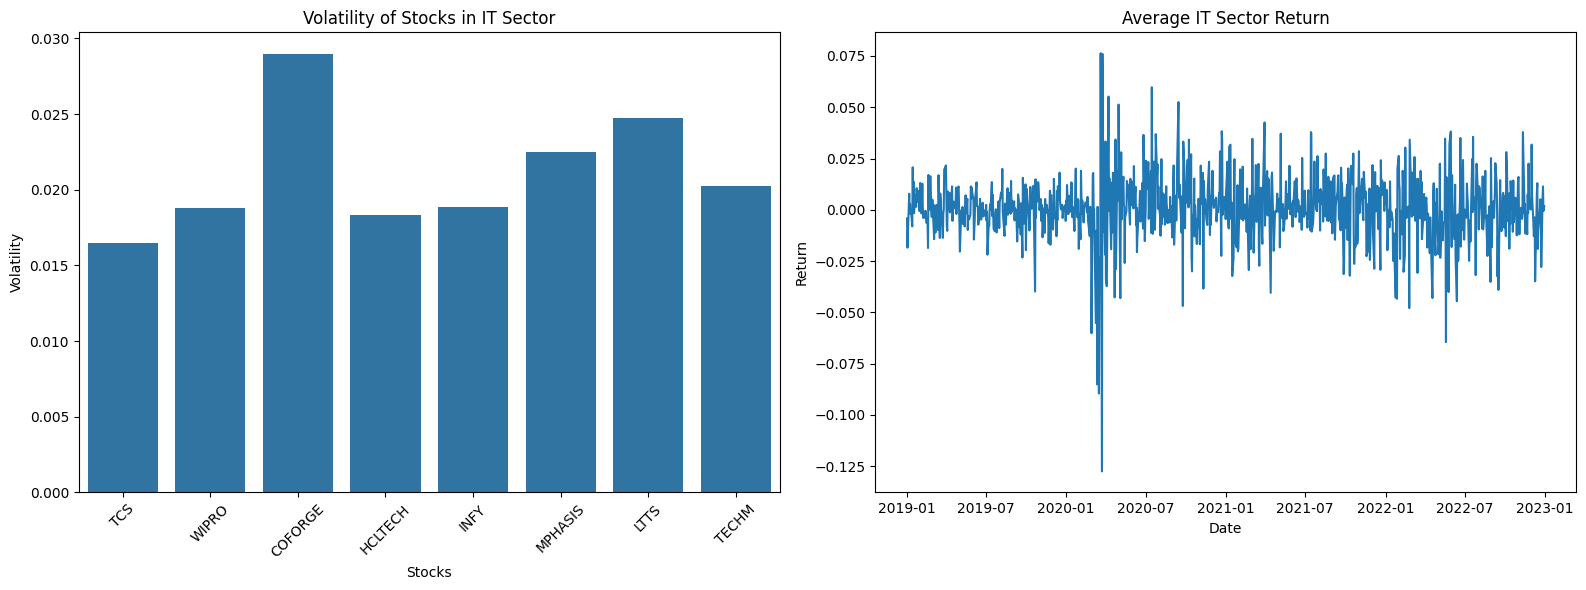

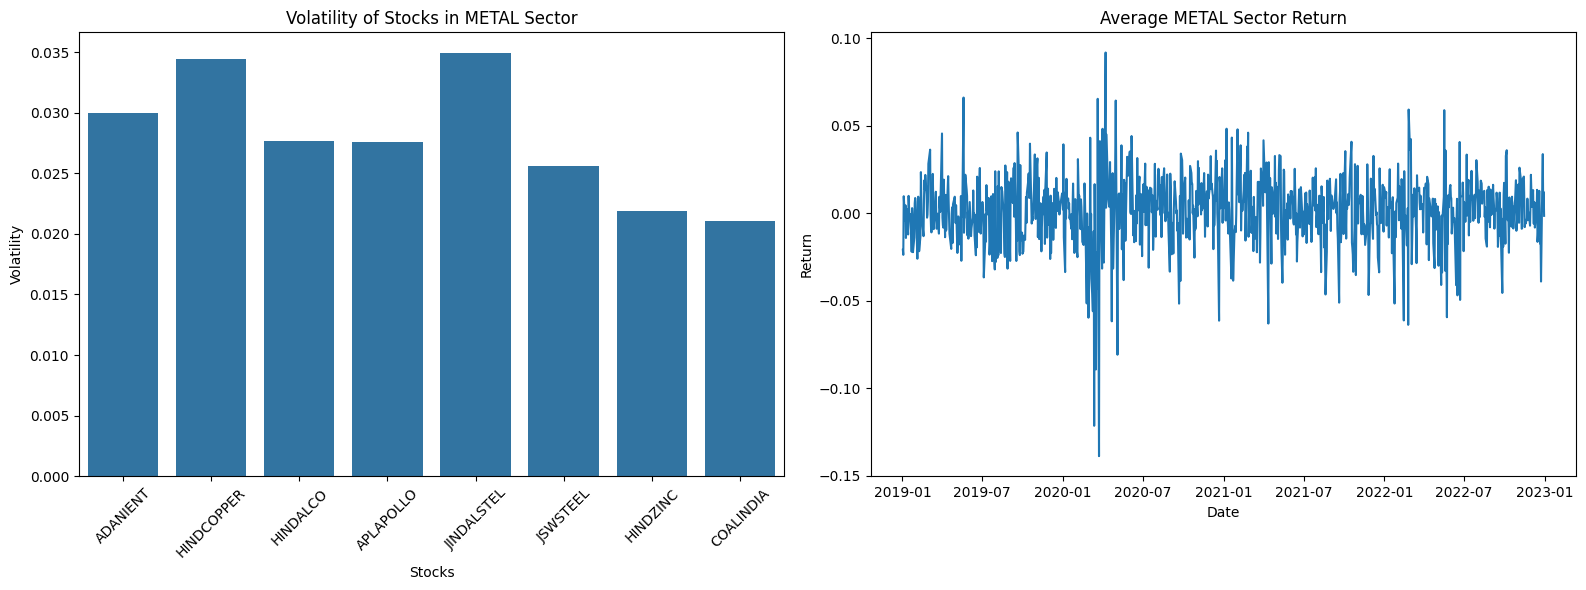

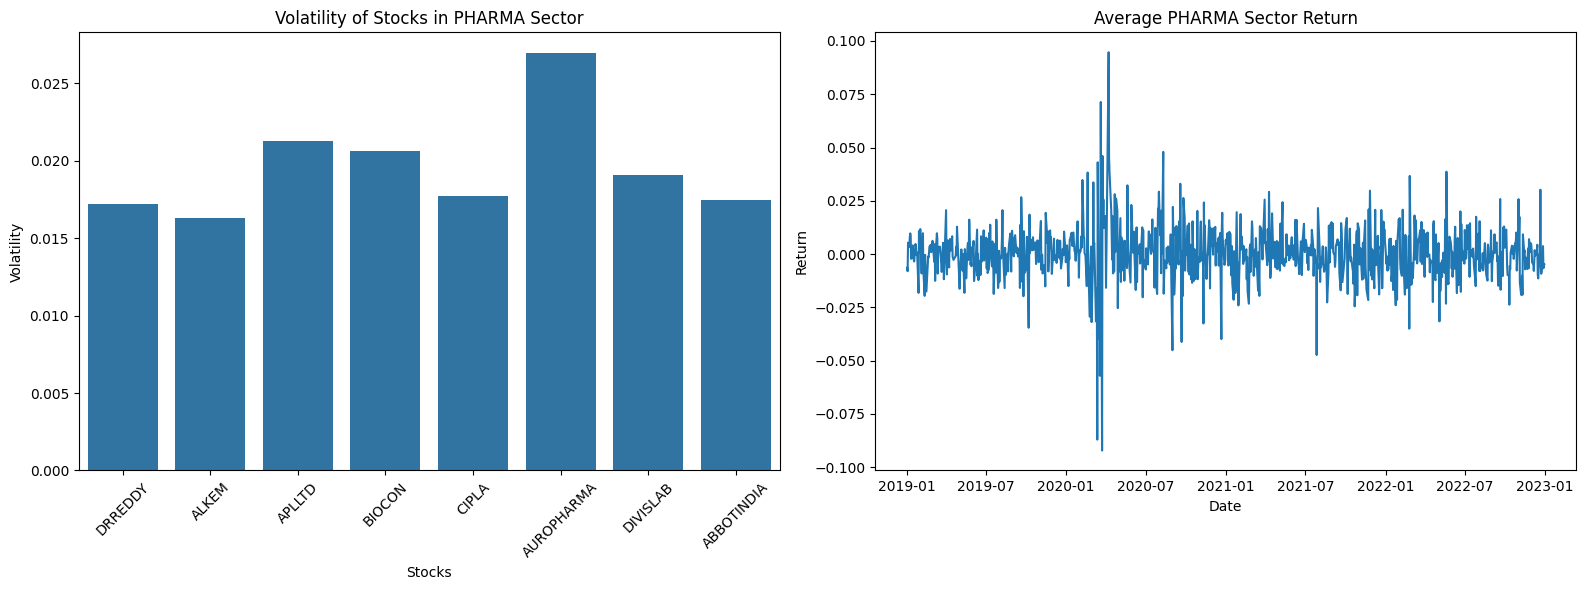

In [2]:
folders = ["STOCKS_NSE_AUTO", "STOCKS_NSE_BANK", "STOCKS_NSE_FMCG", "STOCKS_NSE_IT", "STOCKS_NSE_METAL", "STOCKS_NSE_PHARMA"]

for folder_path in folders:
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    returns_data, stock_volatilities = [], {}

    for f in csv_files:
        df = pd.read_csv(os.path.join(folder_path, f)).dropna()
        df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is in datetime format
        df.set_index('Date', inplace=True)  # Set Date as index
        
        returns_data.append(df['Returns'])
        stock_volatilities[f.replace(".NS_historical_data.csv", "")] = np.std(df['Returns'], ddof=1)

    sector_volatility = np.mean(list(stock_volatilities.values()))
    
    # Compute sector returns with proper Date index
    sector_returns = pd.concat(returns_data, axis=1).mean(axis=1)

    # Create a single figure with 2 subplots (side by side)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Bar plot for stock volatilities
    sns.barplot(x=list(stock_volatilities.keys()), y=list(stock_volatilities.values()), ax=axes[0])
    axes[0].set_title(f"Volatility of Stocks in {folder_path.replace('STOCKS_NSE_', '')} Sector")
    axes[0].set_xlabel("Stocks")
    axes[0].set_ylabel("Volatility")
    
    axes[0].set_xticks(range(len(stock_volatilities)))
    axes[0].set_xticklabels(stock_volatilities.keys(), rotation=45)

    # Plot 2: Line plot for sector returns
    sns.lineplot(x=sector_returns.index, y=sector_returns, ax=axes[1])
    axes[1].set_title(f"Average {folder_path.replace('STOCKS_NSE_', '')} Sector Return")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Return")

    plt.tight_layout()
    plt.show()

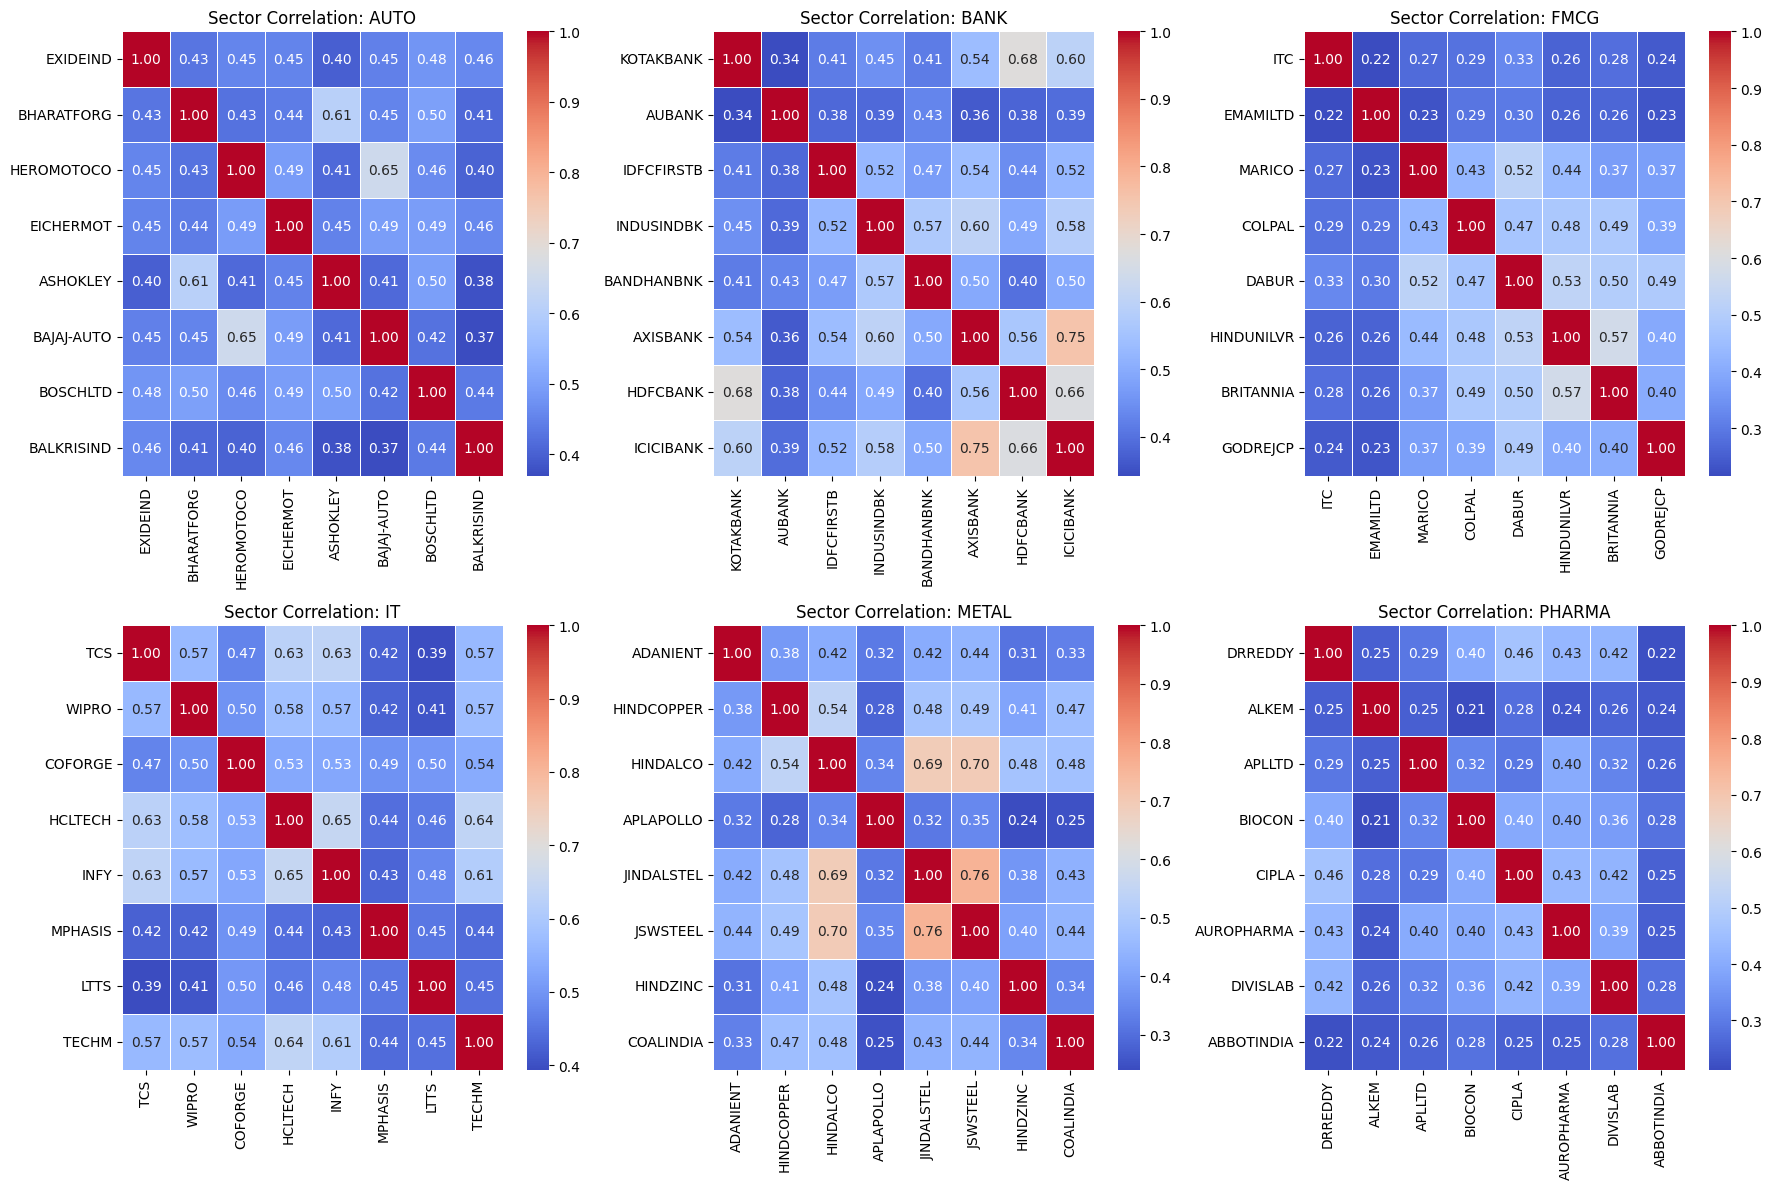

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, folder_path in enumerate(folders):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    stock_returns = {}

    for f in csv_files:
        df = pd.read_csv(os.path.join(folder_path, f)).dropna()
        df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
        stock_returns[f.replace(".NS_historical_data.csv", "")] = df['Returns'].values

    # Compute the correlation matrix
    correlation_matrix = pd.DataFrame(stock_returns).corr()

    # Plot heatmap on corresponding subplot
    ax = axes[i // 3, i % 3]
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=ax)
    ax.set_title(f"Sector Correlation: {folder_path.replace('STOCKS_NSE_', '')}")

plt.tight_layout()
plt.show()

In [4]:
file="SECTOR_INDICES.csv"

sectors = ["AUTO", "BANK", "FMCG", "IT", "METAL", "PHARMA"]

sectors_close = [f"{sec}_CLOSE" for sec in sectors]
df = pd.read_csv(file)
df["DATE"] = pd.to_datetime(df["DATE"], format="mixed", dayfirst=True, errors="coerce")
df.dropna(subset=["DATE"], inplace=True)
df = df.sort_values("DATE")

for sec_cl in sectors_close:
    if sec_cl in df.columns:
        df[f"{sec_cl}_RETURNS"] = np.log(df[sec_cl] / df[sec_cl].shift(1))

df.dropna(inplace=True)
new_order = [col for col in df.columns]
for col in sectors_close:
    if col in df.columns:
        new_order.append(f"{col}_RETURNS")

df = df[new_order]
df.columns = df.columns.str.upper()
df = df.loc[:, ~df.columns.duplicated()]
df.to_csv(file, index=False)

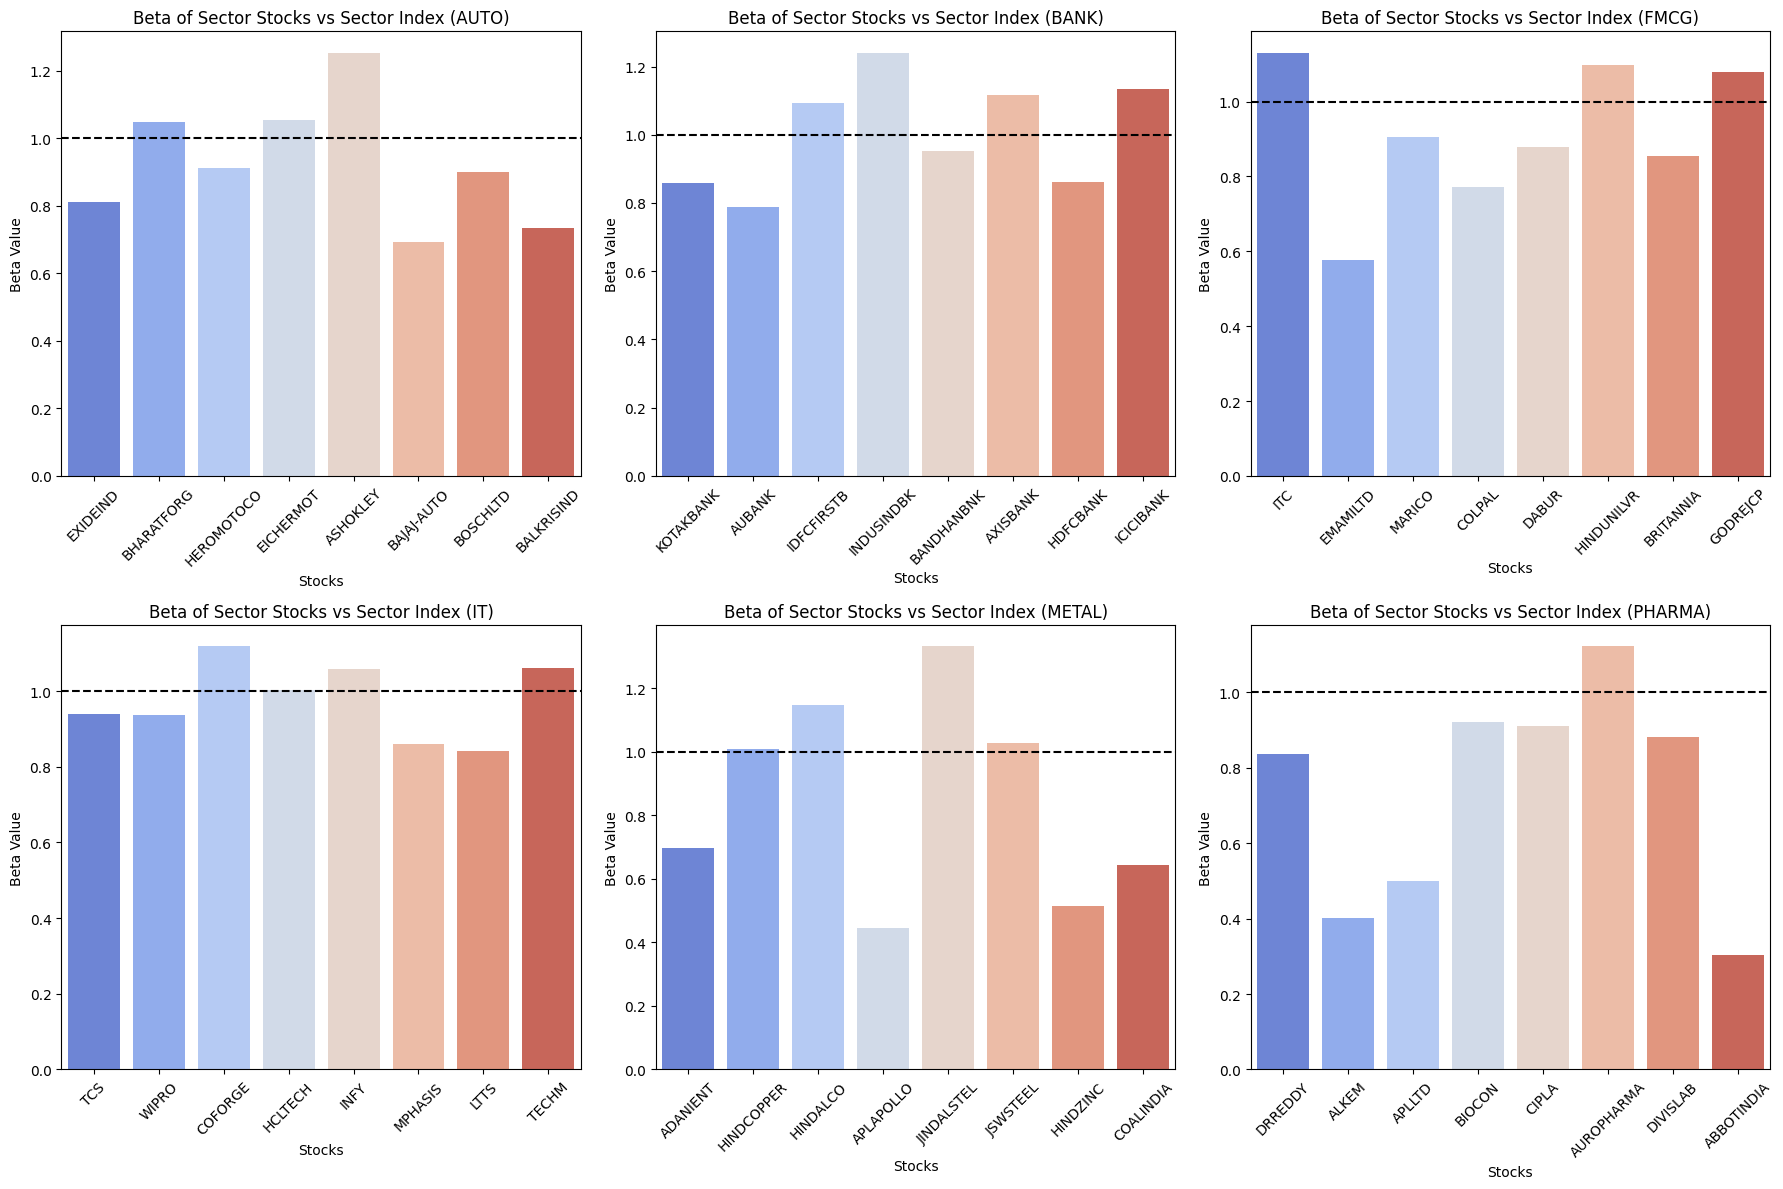

In [5]:
dfsec = pd.read_csv(file)
dfsec["Date"] = pd.to_datetime(dfsec["DATE"])

# Create a grid for 6 sectors (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, sector in enumerate(sectors):
    folder_path = f"STOCKS_NSE_{sector}"
    stock_betas = {}

    # Compute sector returns
    dfsec[f"{sector}_CLOSE_RETURNS"] = dfsec[f"{sector}_CLOSE"].pct_change()

    for f in os.listdir(folder_path):
        if not f.endswith(".csv"):
            continue
        
        df = pd.read_csv(os.path.join(folder_path, f))
        df["Date"] = pd.to_datetime(df["Date"])

        # Merge stock returns with sector returns
        merged_data = pd.merge(
            df[["Date", "Returns"]],
            dfsec[["Date", f"{sector}_CLOSE_RETURNS"]],
            on="Date",
            how="inner"
        ).dropna()

        if merged_data.empty:
            continue

        # Clip extreme values (outliers)
        stock_ret = merged_data["Returns"].clip(merged_data["Returns"].quantile(0.1), merged_data["Returns"].quantile(0.90))
        sec_ret = merged_data[f"{sector}_CLOSE_RETURNS"].clip(merged_data[f"{sector}_CLOSE_RETURNS"].quantile(0.1), merged_data[f"{sector}_CLOSE_RETURNS"].quantile(0.90))

        # Compute Beta
        if np.var(sec_ret) >= 1e-6 and np.var(stock_ret) >= 1e-6:
            beta = np.cov(stock_ret, sec_ret, ddof=0)[0, 1] / np.var(sec_ret, ddof=0)
            stock_betas[f.replace(".NS_historical_data.csv", "")] = beta

    # Plot Beta values for the sector
    if stock_betas:
        ax = axes[i // 3, i % 3]
        sns.barplot(x=list(stock_betas.keys()), y=list(stock_betas.values()), hue=list(stock_betas.keys()), palette="coolwarm", ax=ax, legend=False)
        ax.axhline(y=1, color="black", linestyle="--")
        ax.set_xlabel("Stocks")
        ax.set_ylabel("Beta Value")
        ax.set_title(f"Beta of Sector Stocks vs Sector Index ({sector})")
        
        ax.set_xticks(range(len(stock_betas)))
        ax.set_xticklabels(list(stock_betas.keys()), rotation=45)  # Rotate labels

plt.tight_layout()
plt.show()